### CODING CONVENTION
 
	NAMING
	T = Test-collection  
	M = Measure  
	Q = Query  
	S = Score
	A = Algorithm (that which is usually 'system')
 
	VARIABLE PREFIX
	v = vector
	l = list
	m = matrix
	a = array
	s = string (should be 'c' as in 'character' for R?)
	d = data frame
	w/l = wide/long table format
	f = file name (then what is a string?)

### DATA

* This notebook is a part of a MS Visual Studio 'solution' (collection of projects)
* The Github repository is: [IREval](https://github.com/gechobajar/IREval).
* A download link at the top right of the rendering of this notebook in NBViewer will fetch the notebook itself: a file named _xcollection.ipynb_.
* Clone the Github repository to get the data directory _IREval/xcollection/data_, where the eval files used by the R code are to be found.
* In other words, you could only get the _data_ directory from Github and make sure its in the same directory as _xcollection.ipynb_. The notebook code points to eval files using at a path: _data/xyz_. 



In [1]:
library("reshape2")
library("ggplot2")

# Functions:

# Build the Measure x Query x Score Matrix
#  - Convert long-format table to wide-format table.
#  - Use col 1 as row names and then drop it.
#  - Create matrix from table

MQSMatrix <- function(fEval) {
    vEvalHeader = c("measure", "query", "score")
    dlMQS = read.table(fEval, header = FALSE, col.names = vEvalHeader, na.strings = c("runid", "all"))
    dlMQS = na.omit(dlMQS)
    dwMQS = dcast(dlMQS, measure ~ query, value.var = "score")
    rownames(dwMQS) = dwMQS[, 1]
    dwMQS = dwMQS[, -1]
    mMQS = data.matrix(dwMQS)
    return(mMQS)
}

# Build the Algorithm x Query x Score matrix

AQSMatrix <- function(vfEval) {
    lmEval = lapply(vfEval, function(x) MQSMatrix(x))
    lmAQS = lapply(lmEval, function(z) z["map",])
    vAName = basename(vfEval)
    vQName = names(lmAQS[[1]])
    mAQS = matrix(unlist(lmAQS), nrow = length(vfEval), byrow = T, dimnames = list(vAName, vQName))
    return(mAQS)
}

# Get list of eval files whose names match a regex.

getEvalFileList <- function(regex) {
    vfEval = list.files("data/LTR/evals", pattern = regex, full.names = TRUE)
}
                   
# Convert a matrix to a data-frame

getDataFrameFromMatrix <- function(mMatrix, sColHeader) {
    # mMatrix must have well-defined row-names and column-names.
    # sColHeader is the column header of the new column inserted at left of the data-frame.
    dDataFrame = data.frame(mMatrix, row.names = NULL)
    colnames(dDataFrame) = colnames(mMatrix)
    dDataFrame = cbind(sStubHeader = rownames(mMatrix), dDataFrame)
    names(dDataFrame)[names(dDataFrame) == "sStubHeader"] = sColHeader
    return(dDataFrame)
}

### DEMO

The overall transformation steps:
* Read TRECEVAL output files.
* Convert each file to a MQS matrix.
* Create a list of AQS matrices, one each for a test-collection, from a set of MQS matrices.


#### Derive mMQS: Measure x Query x Score matrix

* Create a R matrix
* Plot that in several ways in an attempt to visualize the matrix, and, validate the plots themselves.
  - persp(): A tessalation of the points in 3D
  - heatmap(): Plots a 2D colored heat-map
  - plot(): Box-plots the rows, i.e. a measure's set of score for all the queries.
  - ggplot() + geom_boxplot(): A more pretty box-plot, preceded by some reshaping of the data to go from a matrix to a long-format table.


                           304     308     314      318       333
bpref                   0.1422  0.1875 0.0e+00 6.80e-03    0.1053
iprec_at_recall_0.00    0.5000  0.5000 2.3e-03 1.80e-03    0.5000
iprec_at_recall_0.10    0.3333  0.5000 0.0e+00 0.00e+00    0.0989
iprec_at_recall_0.20    0.1235  0.5000 0.0e+00 0.00e+00    0.0884
iprec_at_recall_0.30    0.0654  0.0000 0.0e+00 0.00e+00    0.0000
iprec_at_recall_0.40    0.0000  0.0000 0.0e+00 0.00e+00    0.0000
iprec_at_recall_0.50    0.0000  0.0000 0.0e+00 0.00e+00    0.0000
iprec_at_recall_0.60    0.0000  0.0000 0.0e+00 0.00e+00    0.0000
iprec_at_recall_0.70    0.0000  0.0000 0.0e+00 0.00e+00    0.0000
iprec_at_recall_0.80    0.0000  0.0000 0.0e+00 0.00e+00    0.0000
iprec_at_recall_0.90    0.0000  0.0000 0.0e+00 0.00e+00    0.0000
iprec_at_recall_1.00    0.0000  0.0000 0.0e+00 0.00e+00    0.0000
map                     0.0656  0.1250 1.0e-04 0.00e+00    0.0332
num_rel               196.0000  4.0000 4.4e+01 1.13e+02   65.0000
num_rel_re

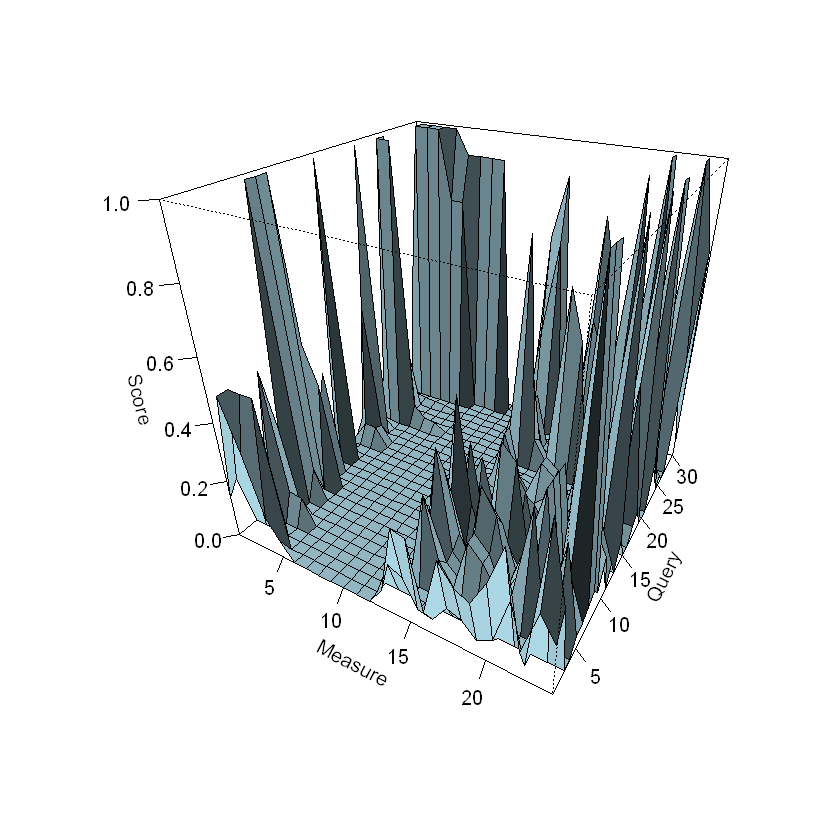

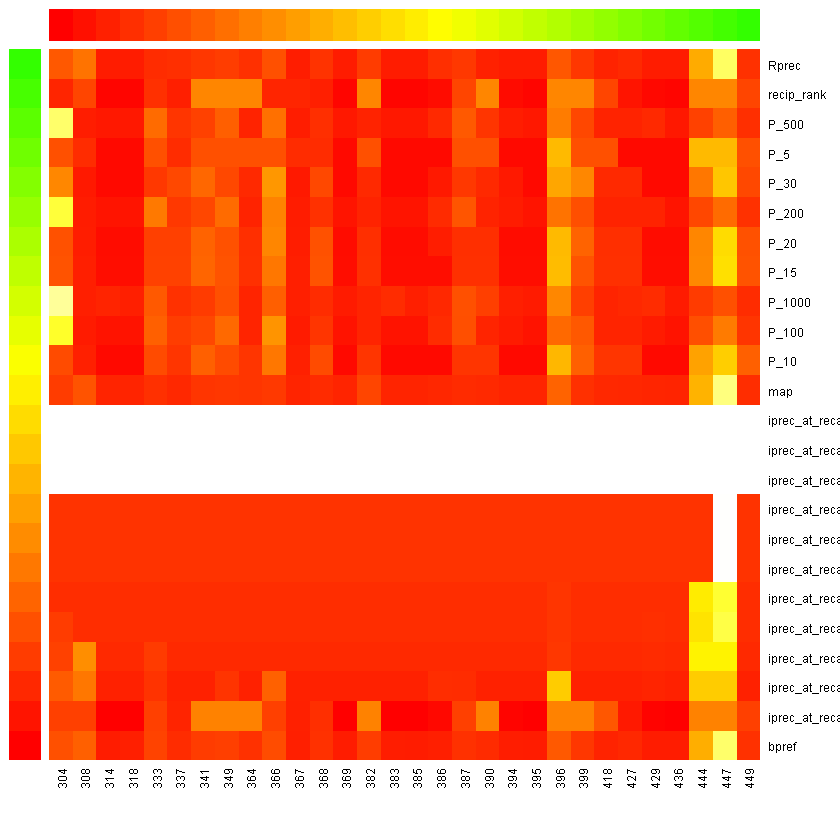

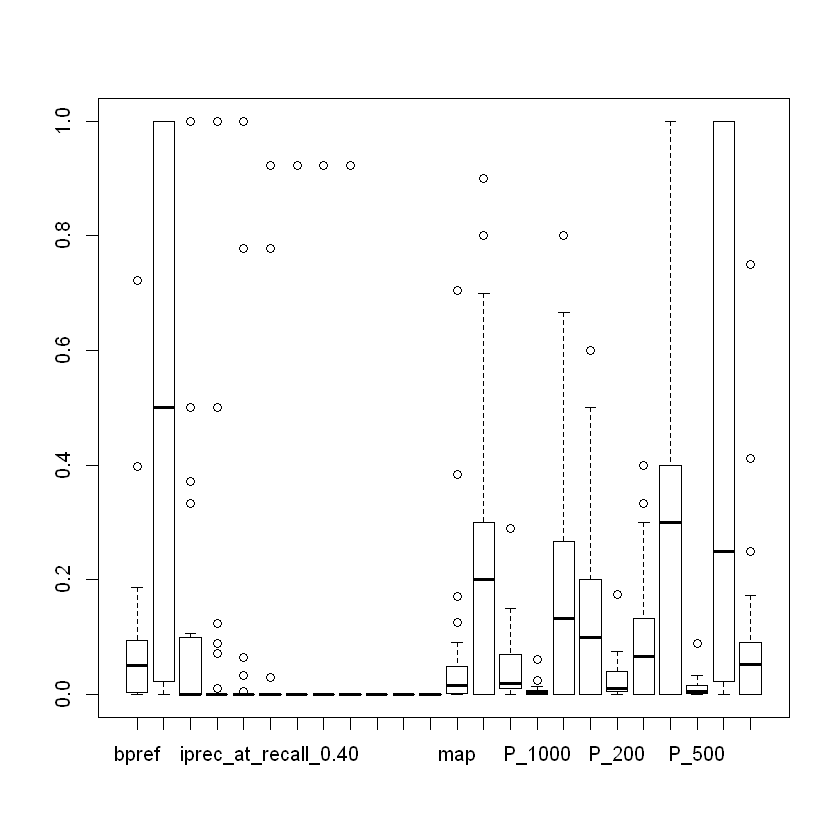

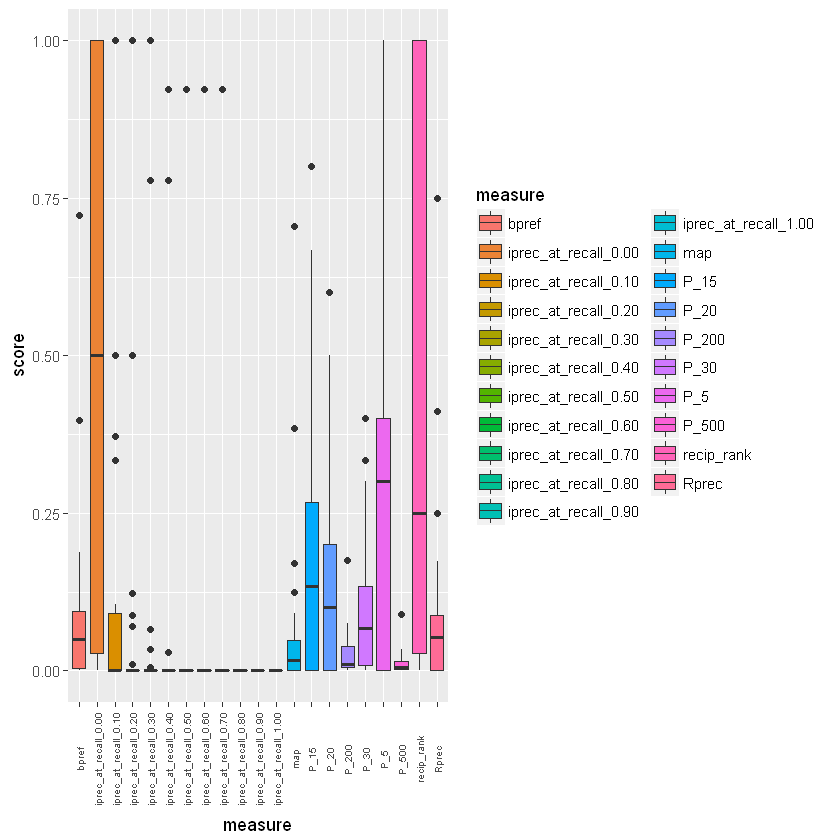

In [2]:
fEval = "data/LTR/evals/FR94.d.p.bm25.30.T.x"
mMQS = MQSMatrix(fEval)
print(mMQS[,1:5])

# Just for fun: plot the mMQS matrix (the plot makes no real sense).
# Rows 14, 15 and 16(num_rel, num_rel_ret, num_ret) were dropped to keep scores within a range that creates a decent picture.
mMQS = mMQS[ - c(14, 15, 16),]
 persp(x = 1:nrow(mMQS), y = 1:ncol(mMQS), z = mMQS, xlab = "Measure", ylab = "Query", zlab = "Score", theta = 30, phi = 30, col = "lightblue", shade = 0.25, ticktype = "detailed")

rc <- rainbow(nrow(mMQS), start = 0, end = .3)
cc <- rainbow(ncol(mMQS), start = 0, end = .3)
heatmap(mMQS, Rowv = NA, Colv = NA, col = heat.colors(256), RowSideColor = rc, ColSideColors = cc)

plot(as.factor(rownames(mMQS)), mMQS)

# Boxplot the eval measures.
# ggplot only consumes data-frames, so convert the matrices first.
dMQS = getDataFrameFromMatrix(mMQS, "measure")
dlMQS = melt(dMQS[ - c(14, 15, 16),], id.vars = "measure", variable.name = "query", value.name = "score")
ggplot(dlMQS, aes(x = measure, y = score, fill = measure)) + geom_boxplot() + theme(strip.text.x = element_text(size = 8, angle = 90), axis.text.x = element_text(angle = 90, vjust = 0.5, size = 6))

#### Derive mAQS: Algorithm x Query x Measure matrix

#### Derive mAQS: Algorithm x Query x Measure matrix

* Create a R matrix by picking a row each from a list of eval-matrices corresponding to a eval-measure.
* Show a 3D tesselation of the points.
* Show a heatmap
* Show a standard box-plot
* Show a pretty ggplot box-plot.

                                304   308   314   318    333
FR94.d.p.bm25.30.T.x         0.0656 0.125 1e-04 0e+00 0.0332
FR94.d.p.bm25e.30.T.x        0.0699 0.125 0e+00 0e+00 0.0322
FR94.d.p.bm25L.30.T.x        0.0648 0.250 1e-04 0e+00 0.0452
FR94.d.p.defaultL.30.T.x     0.0660 0.250 1e-04 0e+00 0.0412
FR94.d.p.dfrL.30.T.x         0.0493 0.250 1e-04 0e+00 0.0303
FR94.d.p.lmdirichletL.30.T.x 0.0548 0.250 0e+00 0e+00 0.0459
FR94.d.x.bm25.30.T.x         0.0516 0.250 1e-04 0e+00 0.0171
FR94.d.x.bm25e.30.T.x        0.0564 0.250 1e-04 0e+00 0.0159
FR94.d.x.bm25L.30.T.x        0.0549 0.250 1e-04 0e+00 0.0360
FR94.d.x.defaultL.30.T.x     0.0543 0.250 1e-04 1e-04 0.0034
FR94.d.x.dfrL.30.T.x         0.0432 0.250 1e-04 0e+00 0.0364
FR94.d.x.lmdirichletL.30.T.x 0.0487 0.250 1e-04 0e+00 0.0321


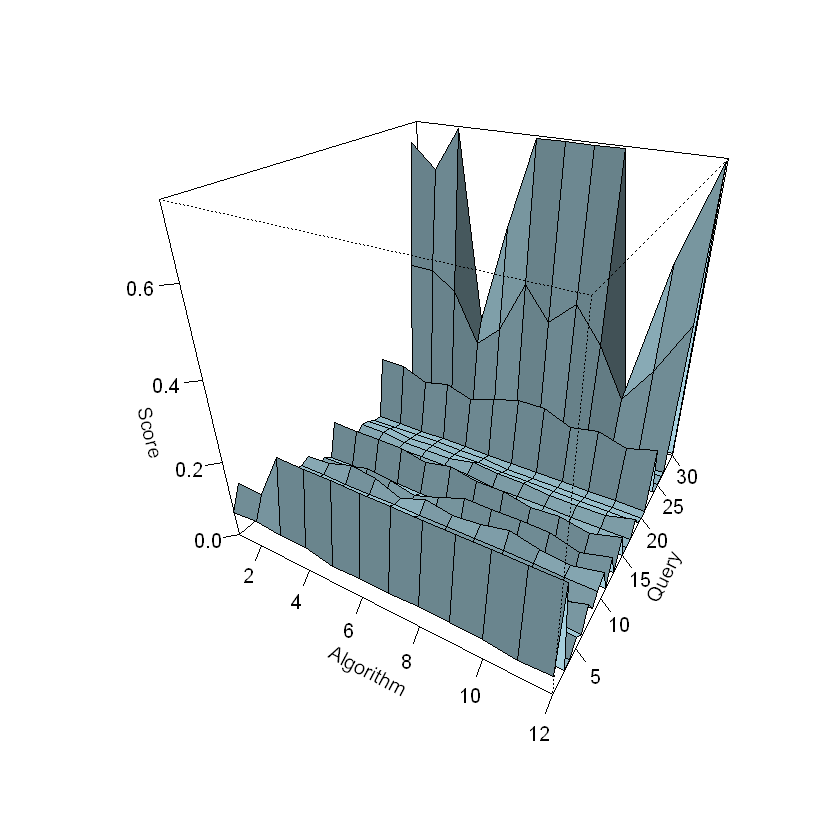

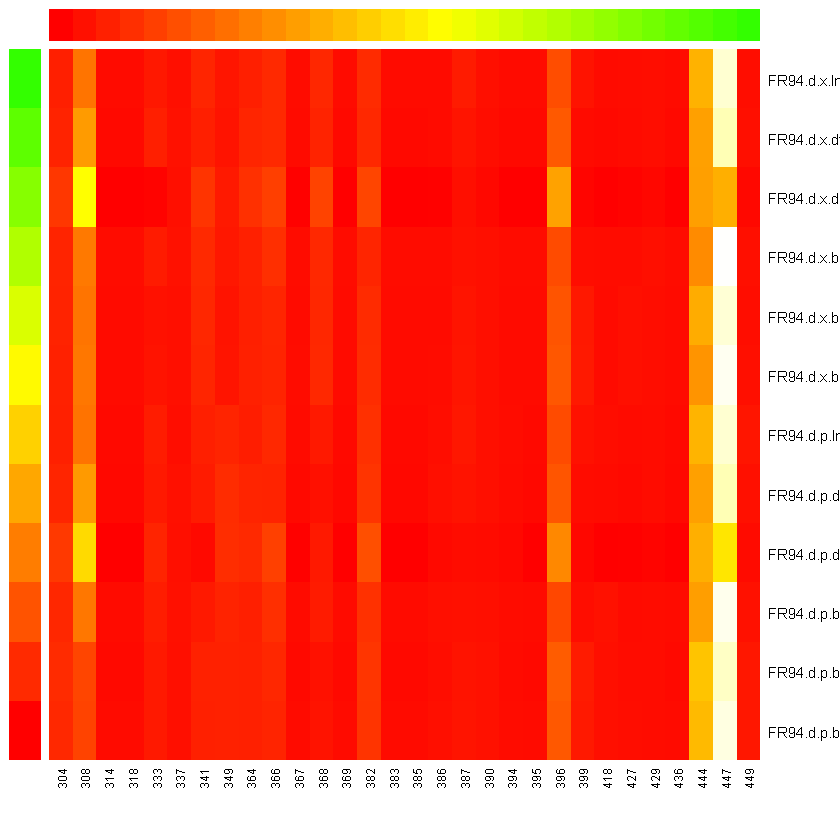

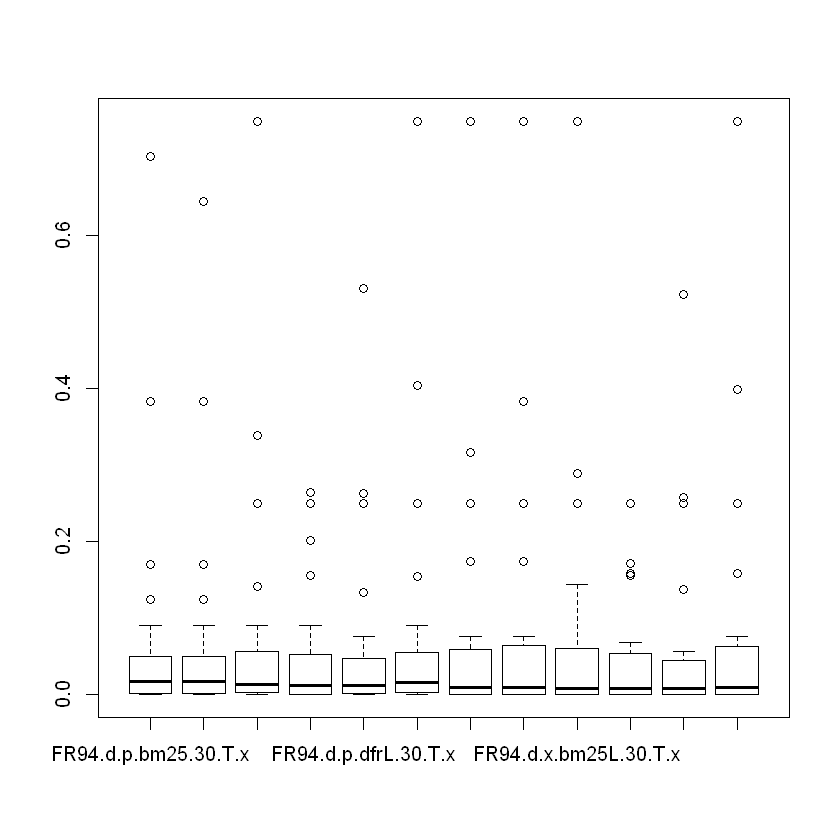

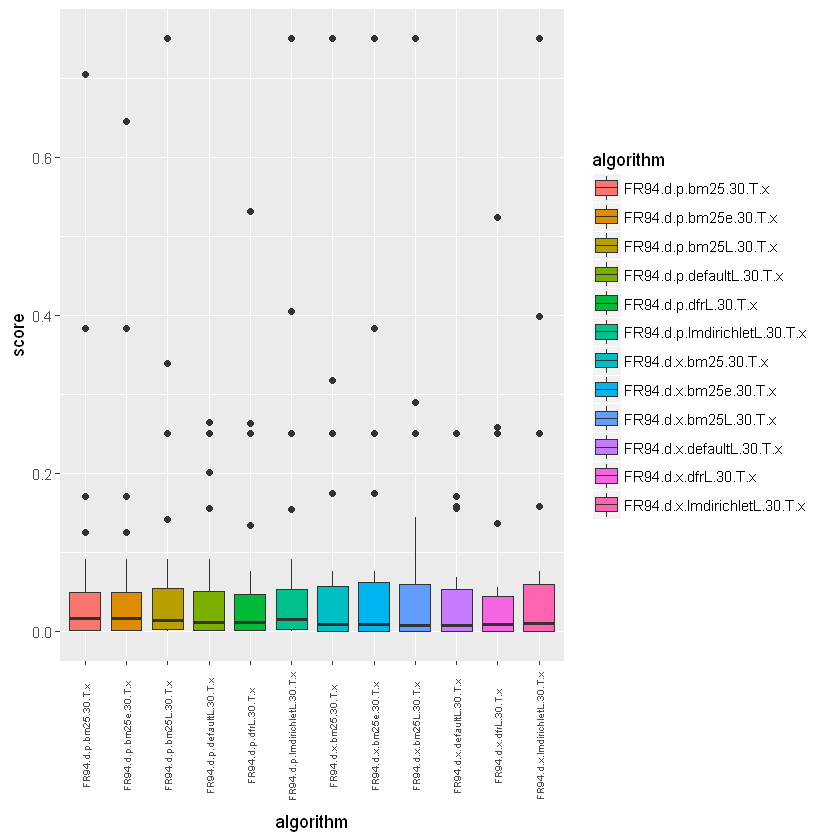

In [3]:
vfEval = getEvalFileList("^FR94\\..*")
mAQS = AQSMatrix(vfEval)
print(mAQS[, 1:5])

persp(x = 1:nrow(mAQS), y = 1:ncol(mAQS), z = mAQS, xlab = "Algorithm", ylab = "Query", zlab = "Score", theta = 30, phi = 30, col = "lightblue", shade = 0.25, ticktype = "detailed")

rc <- rainbow(nrow(mAQS), start = 0, end = .3)
cc <- rainbow(ncol(mAQS), start = 0, end = .3)
heatmap(mAQS, Rowv = NA, Colv = NA, col = heat.colors(256), RowSideColor = rc, ColSideColors = cc)

# Boxplot the algorithms' score.

plot(as.factor(rownames(mAQS)), mAQS)

dAQS = getDataFrameFromMatrix(mAQS, "algorithm")
dlAQS = melt(dAQS, id.vars = "algorithm", variable.name = "query", value.name = "score")
ggplot(dlAQS, aes(x = algorithm, y = score, fill = algorithm)) + geom_boxplot() + theme(strip.text.x = element_text(size = 8, angle = 90), axis.text.x = element_text(angle = 90, vjust = 0.5, size = 6))

#### Derive lmAQS: A list of mAQS matrices, one each for a test-collections.

In [4]:
vTName = c("AP", "DOE", "FR")
lTIndex = setNames(as.list(1:length(vTName)), vTName)
vfEvalRgx = paste("^", vTName, "\\.", sep = "")
lmAQS = lapply(vfEvalRgx, function(x) {y = getEvalFileList(x); AQSMatrix(y)})

# Part of a matrix from lmAQS for the AP and DOE test-collection.
print(lmAQS[[lTIndex[["AP"]]]][, 1:5])
print(lmAQS[[lTIndex[["DOE"]]]][, 1:5])

                                 1      2      3      4      5
AP.d.p.bm25.196.T.x         0.0367 0.0256 0.1286 0.1624 0.0906
AP.d.p.bm25e.196.T.x        0.0317 0.0256 0.1289 0.1626 0.0934
AP.d.p.bm25L.196.T.x        0.0442 0.0144 0.1176 0.1925 0.0937
AP.d.p.defaultL.196.T.x     0.0358 0.0094 0.1119 0.1356 0.1007
AP.d.p.dfrL.196.T.x         0.0393 0.0146 0.1159 0.2073 0.0810
AP.d.p.lmdirichletL.196.T.x 0.0474 0.0221 0.1283 0.1590 0.0697
AP.d.x.bm25.196.T.x         0.0282 0.0269 0.0385 0.0726 0.1224
AP.d.x.bm25e.196.T.x        0.0230 0.0269 0.0384 0.0726 0.1224
AP.d.x.bm25L.196.T.x        0.0357 0.0123 0.0351 0.1127 0.1449
AP.d.x.defaultL.196.T.x     0.0252 0.0109 0.0291 0.0561 0.1458
AP.d.x.dfrL.196.T.x         0.0275 0.0124 0.0376 0.1044 0.1393
AP.d.x.lmdirichletL.196.T.x 0.0390 0.0213 0.0315 0.0758 0.1387
                                 3      7     8     11     12
DOE.d.p.bm25.80.T.x         1.0000 0.0119 0e+00 0.0098 0.0609
DOE.d.p.bm25e.80.T.x        1.0000 0.0119 0e+00 0.0055 0.

#### Derive mATS: Algorithm x Test-collection x Score matrix

* Scores are Mean-scores (MAP, in this case) from each matrix in lmAQS, for all test-collections
* Followed by a plot.

     d.p.bm25 d.p.bm25e d.p.bm25L d.p.defaultL  d.p.dfrL
AP  0.2195990 0.2094714 0.2247745     0.216199 0.2215148
DOE 0.1728263 0.1818350 0.1477962     0.146970 0.1449250
FR  0.2013282 0.1998427 0.1910736     0.182650 0.1436773


Using Algorithm as id variables


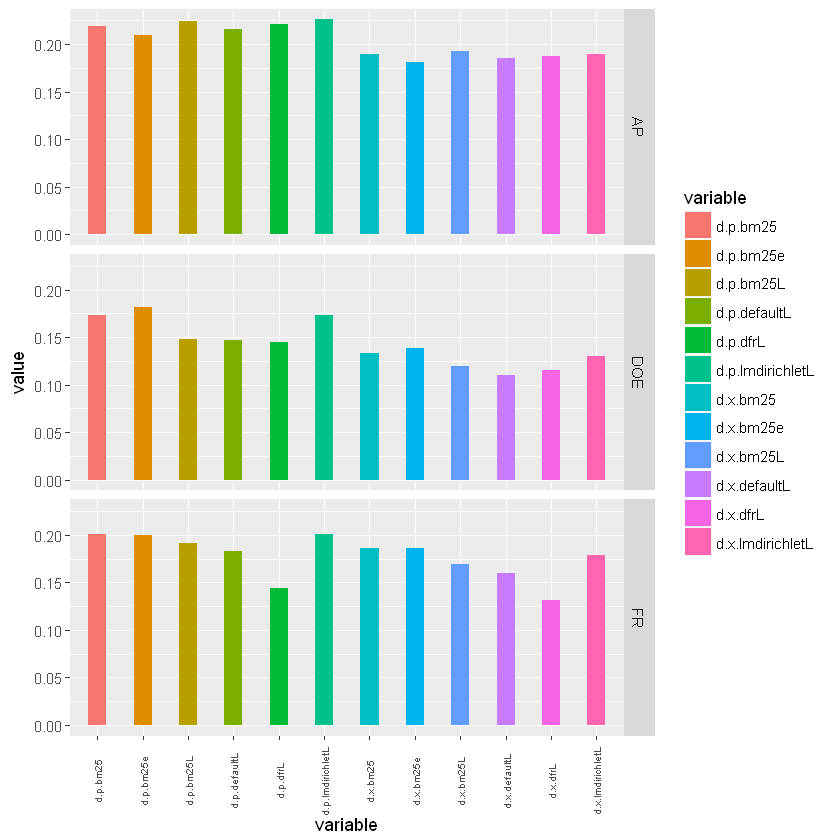

In [5]:
# Chris's table: Algorithm x Testcol x Mean Score
lvRowMean = lapply(vTName, function(x) rowMeans(lmAQS[[lTIndex[[x]]]]))
vColName = rownames(lmAQS[[lTIndex[[1]]]])
vAName = sapply(strsplit(vColName, "[.]"), function(x) paste(x[2:4], collapse = "."))
mATS = matrix(unlist(lvRowMean), nrow = length(vTName), byrow = T, dimnames = list(vTName, vAName))
print(mATS[, 1:5])

# Plot mATS
dATS = data.frame(mATS)
dATS[, "Algorithm"] = rownames(dATS)
dlATS = melt(dATS)
ggplot(dlATS, aes(variable, value, fill = variable)) + geom_bar(width = 0.4, stat = "identity") + facet_grid(Algorithm ~ .) + theme(strip.text.x = element_text(size = 8, angle = 90), axis.text.x = element_text(angle = 90, vjust = 0.5, size = 6))